In [11]:
%matplotlib notebook
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json, time, datetime, math
import operator

now = datetime.datetime.now()
ROOT_PATH = 'data/'
DATA_PATH = '-'.join(str(x) for x in [(now.year), now.month, now.day])
LOAD_DATA_PATH = '2018-2-5'

def sorted_df(cen):
    return pd.DataFrame(sorted(cen.items(), key=operator.itemgetter(1), reverse=True))

def print_time(msg, unix):
    print(msg, time.ctime(int(unix)))
    
def get_readable_time(unix):
    return [time.ctime(int(u)) for u in unix]

def print_progress(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, errors = 0, fill = '+'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s - errors: %s' % (prefix, bar, percent, suffix, errors), end = '\r')
    # Print New Line on Complete
    if iteration == (total - 2): 
        print()

In [13]:
submissions = pd.read_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'submissions.pkl').query('author!="[deleted]"')
comments = pd.read_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'comments.pkl').query('author!="[deleted]"')
comments[['parent_type','parent_id']] = comments['parent_id'].str.split('_',expand=True)
submissions = submissions.query('subreddit=="Bitcoin"')

In [14]:
authors_1 = pd.DataFrame({
    'author': submissions['author']
})

authors_2 = pd.DataFrame({
    'author': comments['author']
}) 

authors = pd.concat([authors_1, authors_2]).drop_duplicates().reset_index(drop=True)
authors.info()

print('num_comments:', comments.query('parent_type=="t1"')['parent_type'].count())
print('num_links:', comments.query('parent_type=="t3"')['parent_type'].count())
print('total:', comments['id'].count())

#625480

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37833 entries, 0 to 37832
Data columns (total 1 columns):
author    37833 non-null object
dtypes: object(1)
memory usage: 295.6+ KB
num_comments: 129735
num_links: 44413
total: 174148


In [15]:
edges_sub = pd.merge(
    comments[comments['parent_type'] == 't3'].reset_index(),
    submissions, 
    left_on='parent_id', 
    right_on='id', 
    how='left', 
    suffixes=('_left', '_right')
)
edges_sub = edges_sub.query('author_left != "[deleted]" & author_right != "[deleted]"').reset_index(drop=True)
edges_sub = edges_sub.query('author_left != author_right').reset_index(drop=True)
edge_fields_sub = ['author_left', 'author_right', 'score_left', 'id_left', 'id_right', 'subreddit_left']
edges_sub = edges_sub[edge_fields_sub]
edges_sub['weight'] = edges_sub['score_left']
edges_sub['type'] = 'com_on_sub'
edges_sub = edges_sub.rename(columns={'subreddit_left': 'subreddit'})

edges_com = pd.merge(
    comments[comments['parent_type'] == 't1'].reset_index(), 
    comments, 
    left_on='parent_id', 
    right_on='id', 
    how='left', 
    suffixes=('_left', '_right')
)

edge_fields = ['author_left', 'author_right', 'score_left', 'id_left', 'id_right', 'subreddit_left']
edges_com = edges_com[edge_fields]
edges_com['weight'] = edges_com['score_left']
edges_com['type'] = 'com_on_com'
edges_com = edges_com.rename(columns={'subreddit_left': 'subreddit'})

In [16]:
g = nx.from_pandas_dataframe(
    pd.concat([edges_sub, edges_com], ignore_index=True), 
    'author_left', 
    'author_right', 
    ['weight', 'score_left', 'id_left', 'id_right', 'subreddit', 'type'], 
    create_using=nx.MultiDiGraph()
)
print(nx.info(g))

Name: 
Type: MultiDiGraph
Number of nodes: 34344
Number of edges: 173817
Average in degree:   5.0611
Average out degree:   5.0611


In [17]:
#Koliko drugih ljudi data osoba može direktno kontaktirati?
print(nx.info(g))
deg_cen = sorted_df(nx.degree_centrality(g))
max_num = 30
print(30*'-')
print(deg_cen[0:max_num])

Name: 
Type: MultiDiGraph
Number of nodes: 34344
Number of edges: 173817
Average in degree:   5.0611
Average out degree:   5.0611
------------------------------
                       0         1
0            rBitcoinMod  0.128993
1              lriccardo  0.036485
2              BluntLord  0.028507
3               mdk72002  0.028361
4                    NaN  0.026934
5          CONTROLurKEYS  0.025682
6         Arachnocentric  0.023877
7                  B3nGG  0.023615
8            i_gotta_say  0.019101
9   entrepreneurharshita  0.018810
10             Mayhembit  0.018170
11             suninabox  0.017646
12        TheGreatMuffin  0.016743
13      highly_memorable  0.016248
14            bitsteiner  0.016015
15       DesignerAccount  0.015986
16              RulerZod  0.015869
17                ebaley  0.015724
18              wallyjo3  0.015200
19       throwawayTooFit  0.015170
20                boxhit  0.015083
21          xcryptogurux  0.015054
22            pilotavery  0.014472

In [ ]:
#Koliko brzo data osoba može dopreti do svake druge osobe u mreži?
closeness_cen = sorted_df(nx.closeness_centrality(g))
print(30*'-')
print(closeness_cen[0:max_num])

In [ ]:
#Koliko je verovatno da će data osoba imati ulogu posrednika između nekih drugih dvoje ljudi iz mreže?
betweenness_cen = sorted_map(nx.betweenness_centrality(g))
print(30*'-')
print(betweenness_cen[0:max_num])

In [ ]:
data_df = pd.DataFrame({
    'degree_cen': dict(deg_cen),
    'betweenness_cen': dict(betweenness_cen),
    'closeness_cen': dict(closeness_cen) 
})

data_df.to_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'graph_data.pkl')

In [ ]:
data_df = pd.read_pickle(ROOT_PATH + LOAD_DATA_PATH + '/' + 'graph_data.pkl')

In [9]:

def top_n_trim(g, sorted_map, n=20):
    g2 = g.copy()
    pick_list = []
    for item in deg_cen:
        pick_list.append(item[0])
        if len(pick_list) >= 20:
            break
    for n in g.nodes():
        if n not in pick_list:
            g2.remove_node(n)
        #break
    return g2
        
gg = top_n_trim(g, deg_cen, n=20)
print(len(gg))

20


1209
20


<IPython.core.display.Javascript object>


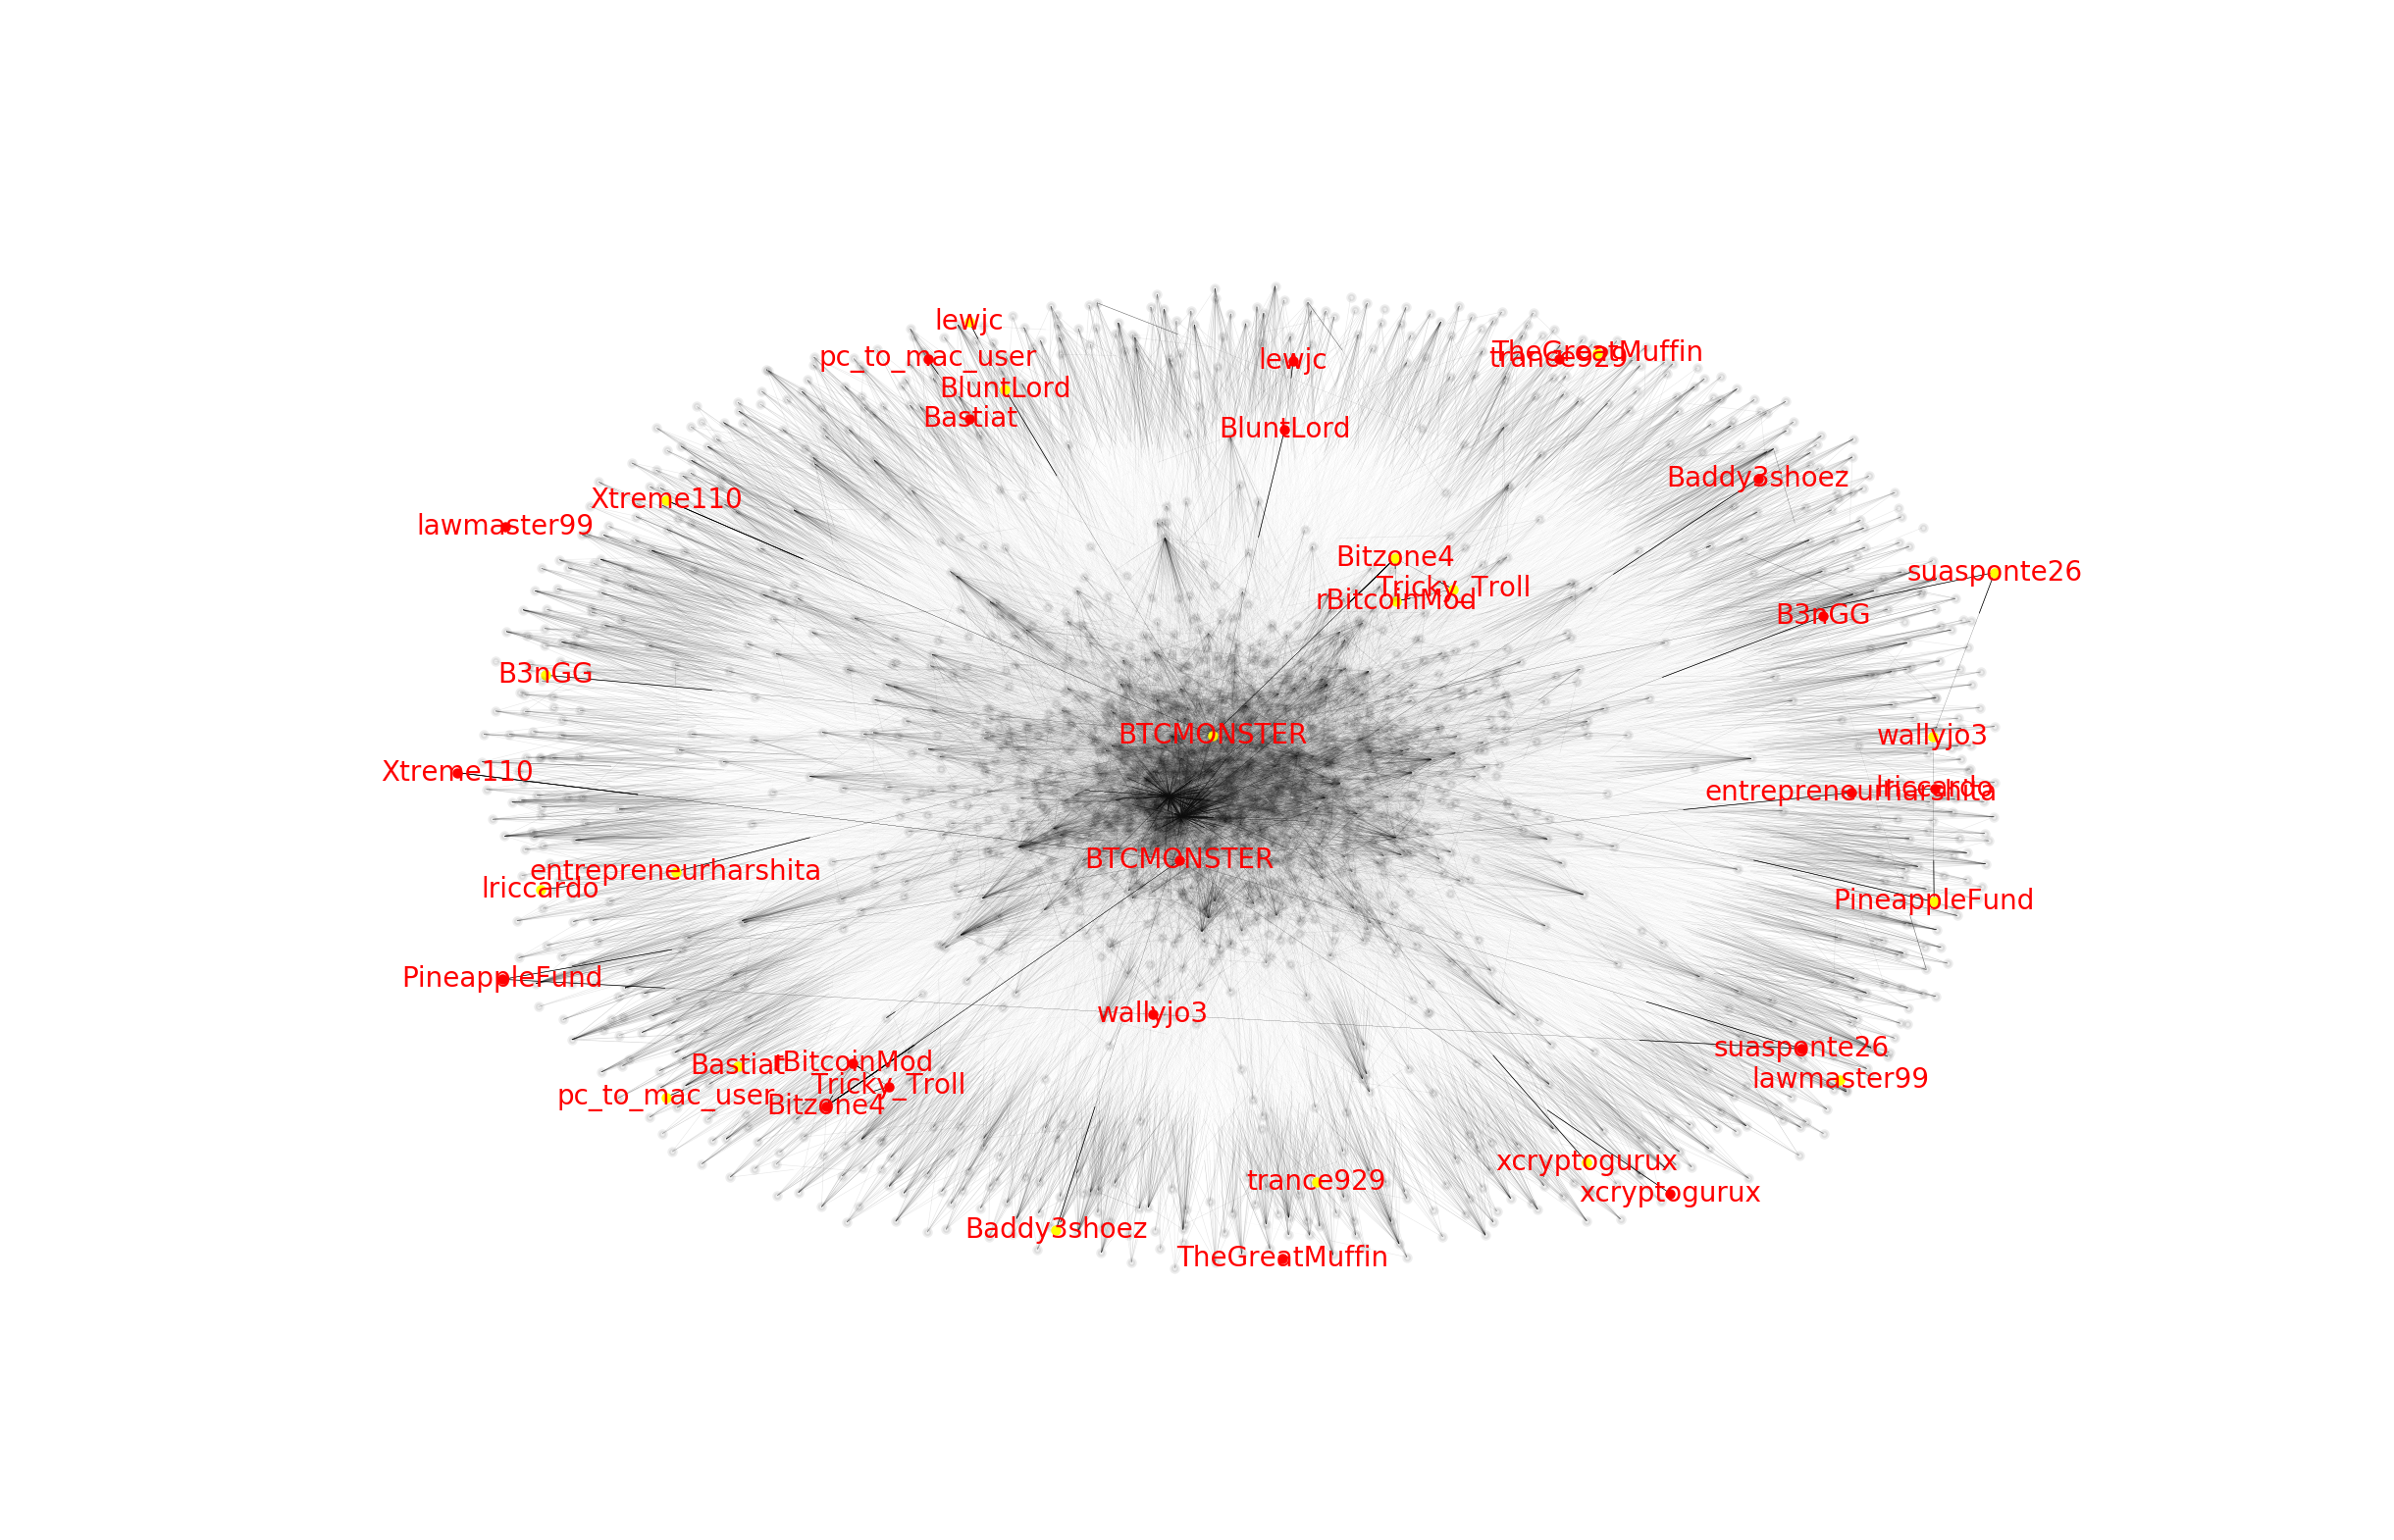

In [11]:
def trim_degrees(g, degree=1):
    g2 = g.copy()
    d = nx.degree(g2)
    for n in g.nodes():
        if d[n]<=degree:
            g2.remove_node(n)
    return g2

core = trim_degrees(g, degree=10)
print(len(core))
#core2 = trim_degrees(g, degree=150)
core2 = top_n_trim(g, deg_cen, n=25)
print(len(core2))

<IPython.core.display.Javascript object>


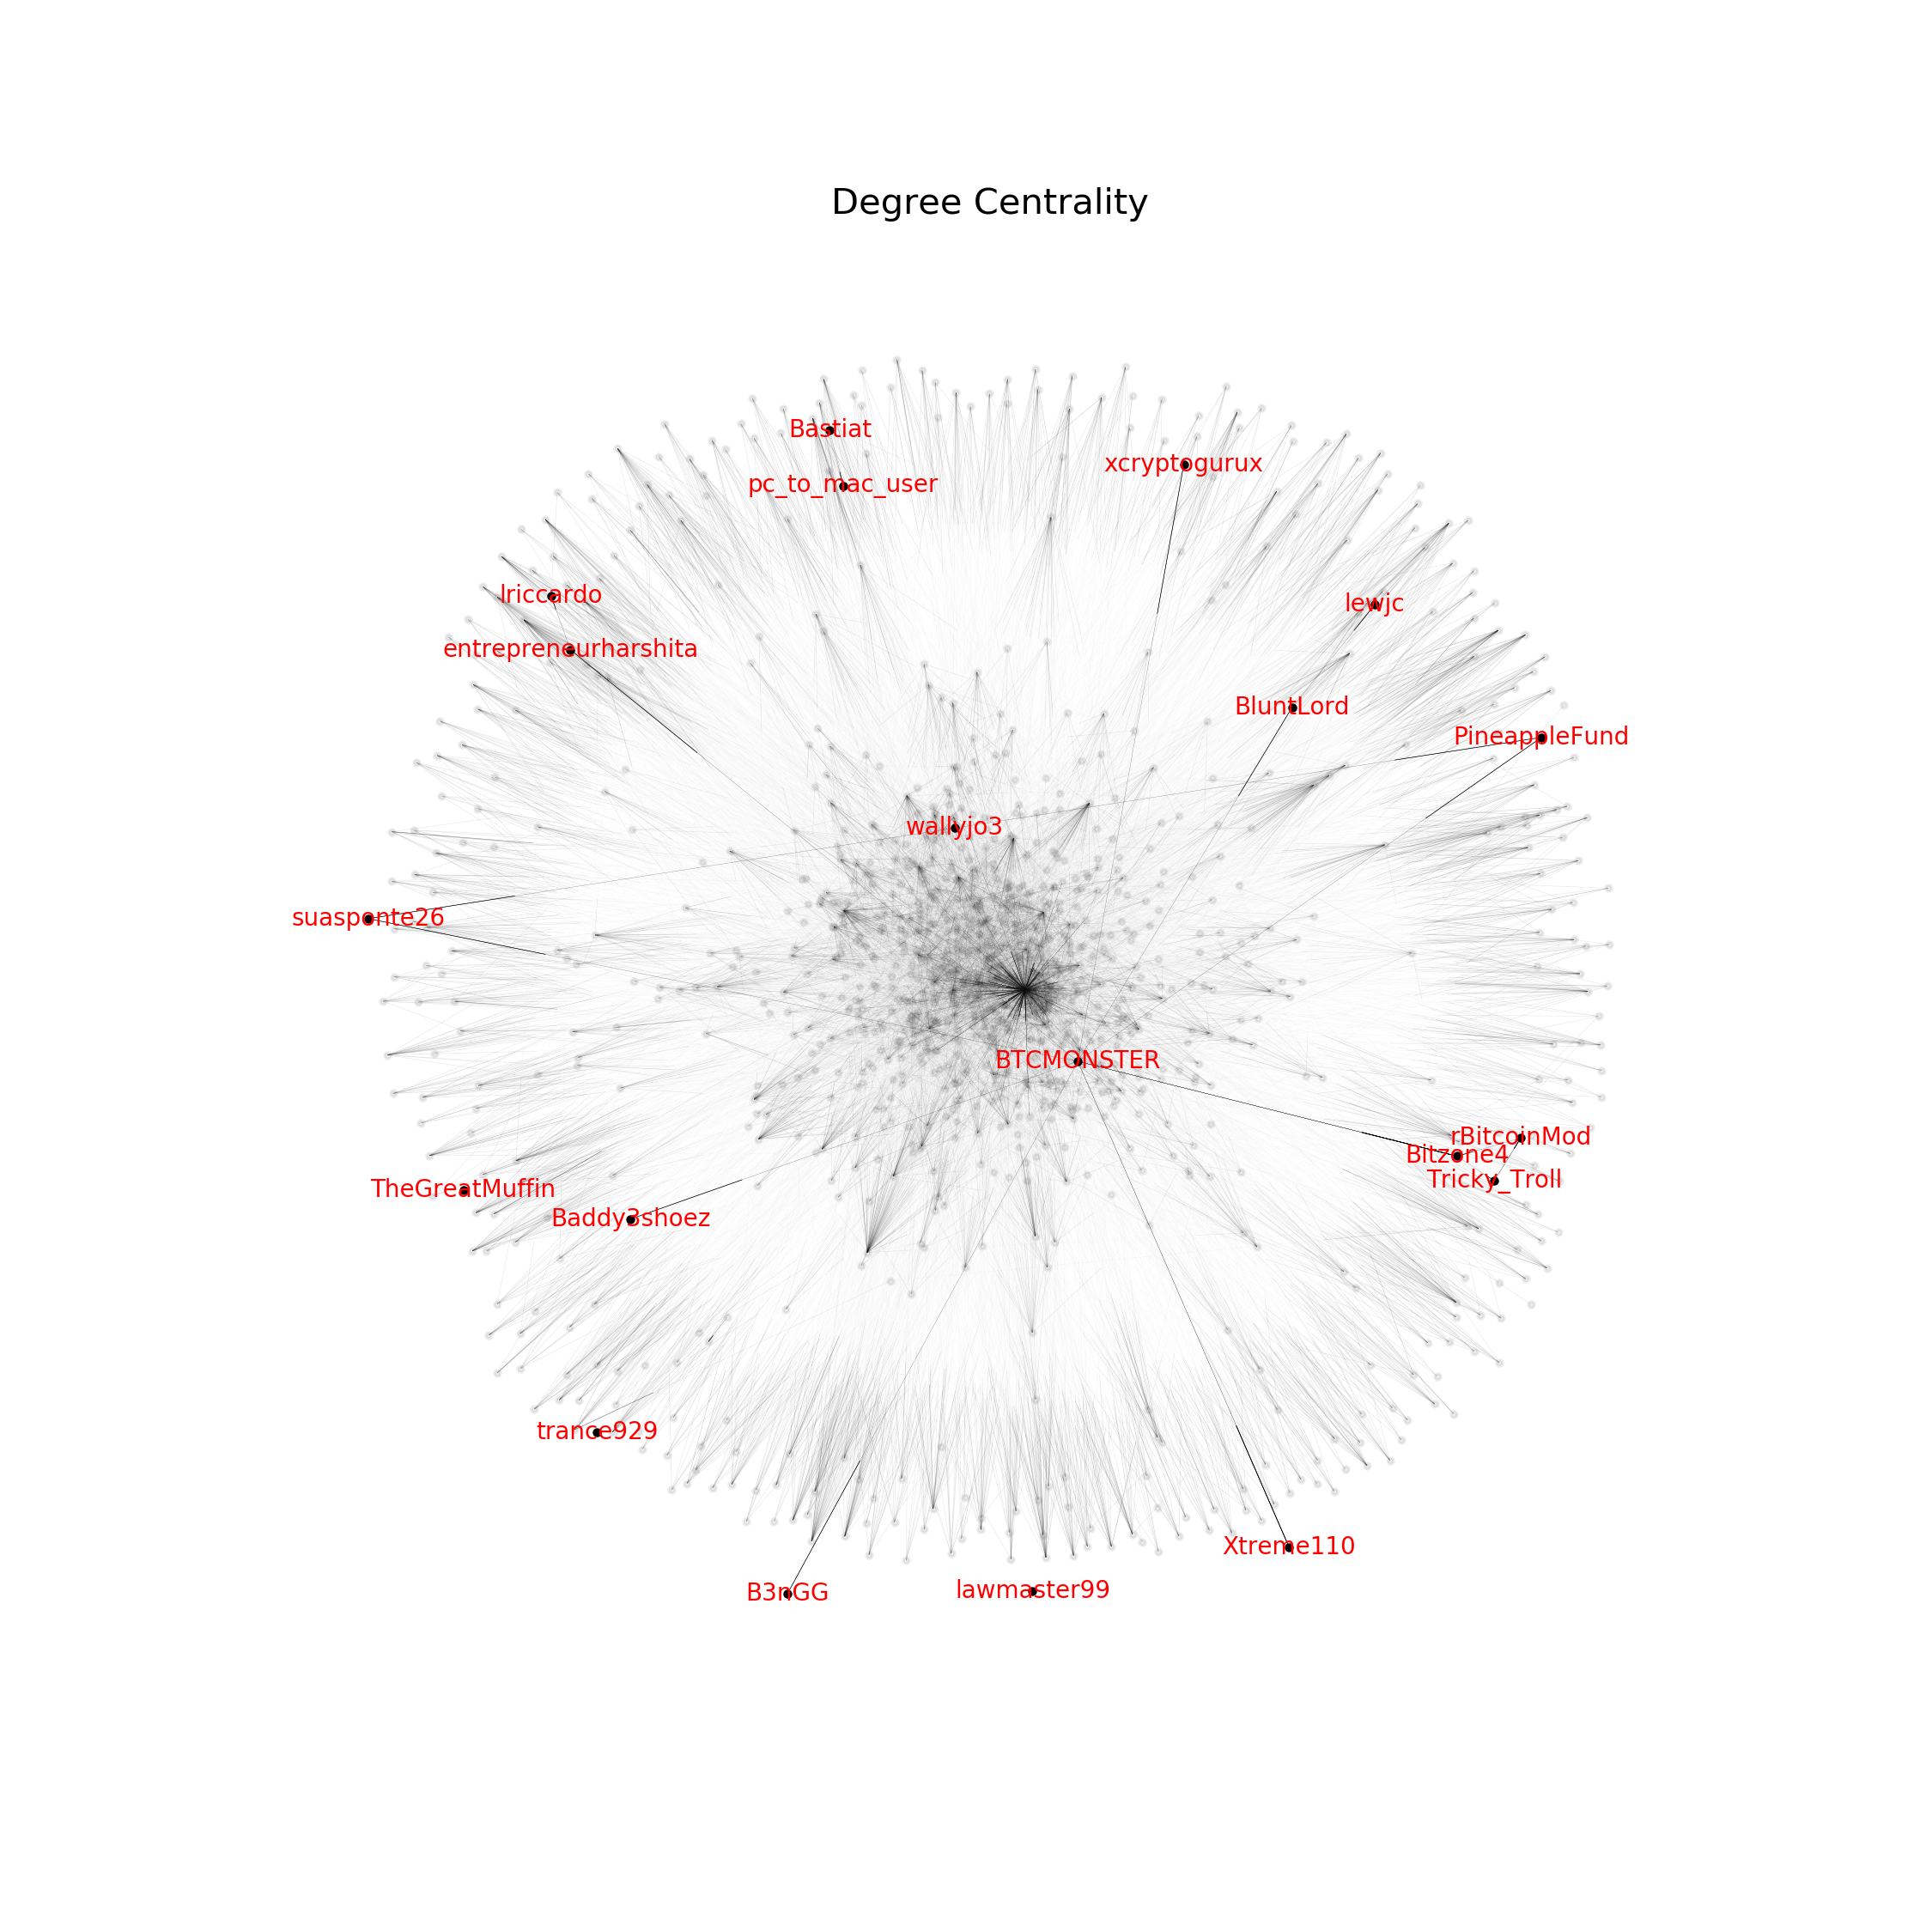

[]

In [28]:
options = {
    'node_color': 'black',
    'node_size': 4,
    'width': 0.05,
    'font_size': 8
}

fig1 = plt.figure(figsize=(9,9))
ax1 = fig1.add_subplot(111)
nx.draw_networkx(core, with_labels=False, font_color='black', alpha=0.07, **options)
nx.draw_networkx(core2, with_labels=True, font_color='red', **options)
#nx.draw_networkx(core, with_labels=False, font_size=9, font_color='b', width=0.05, node_size=4, alpha=0.07, node_color='black')
#nx.draw_networkx(core2, with_labels=True, font_size=8, font_color='r', width=0.05, node_size=4, node_color='yellow')
plt.title('Degree Centrality')
plt.axis('off')
ax1.plot()


<IPython.core.display.Javascript object>


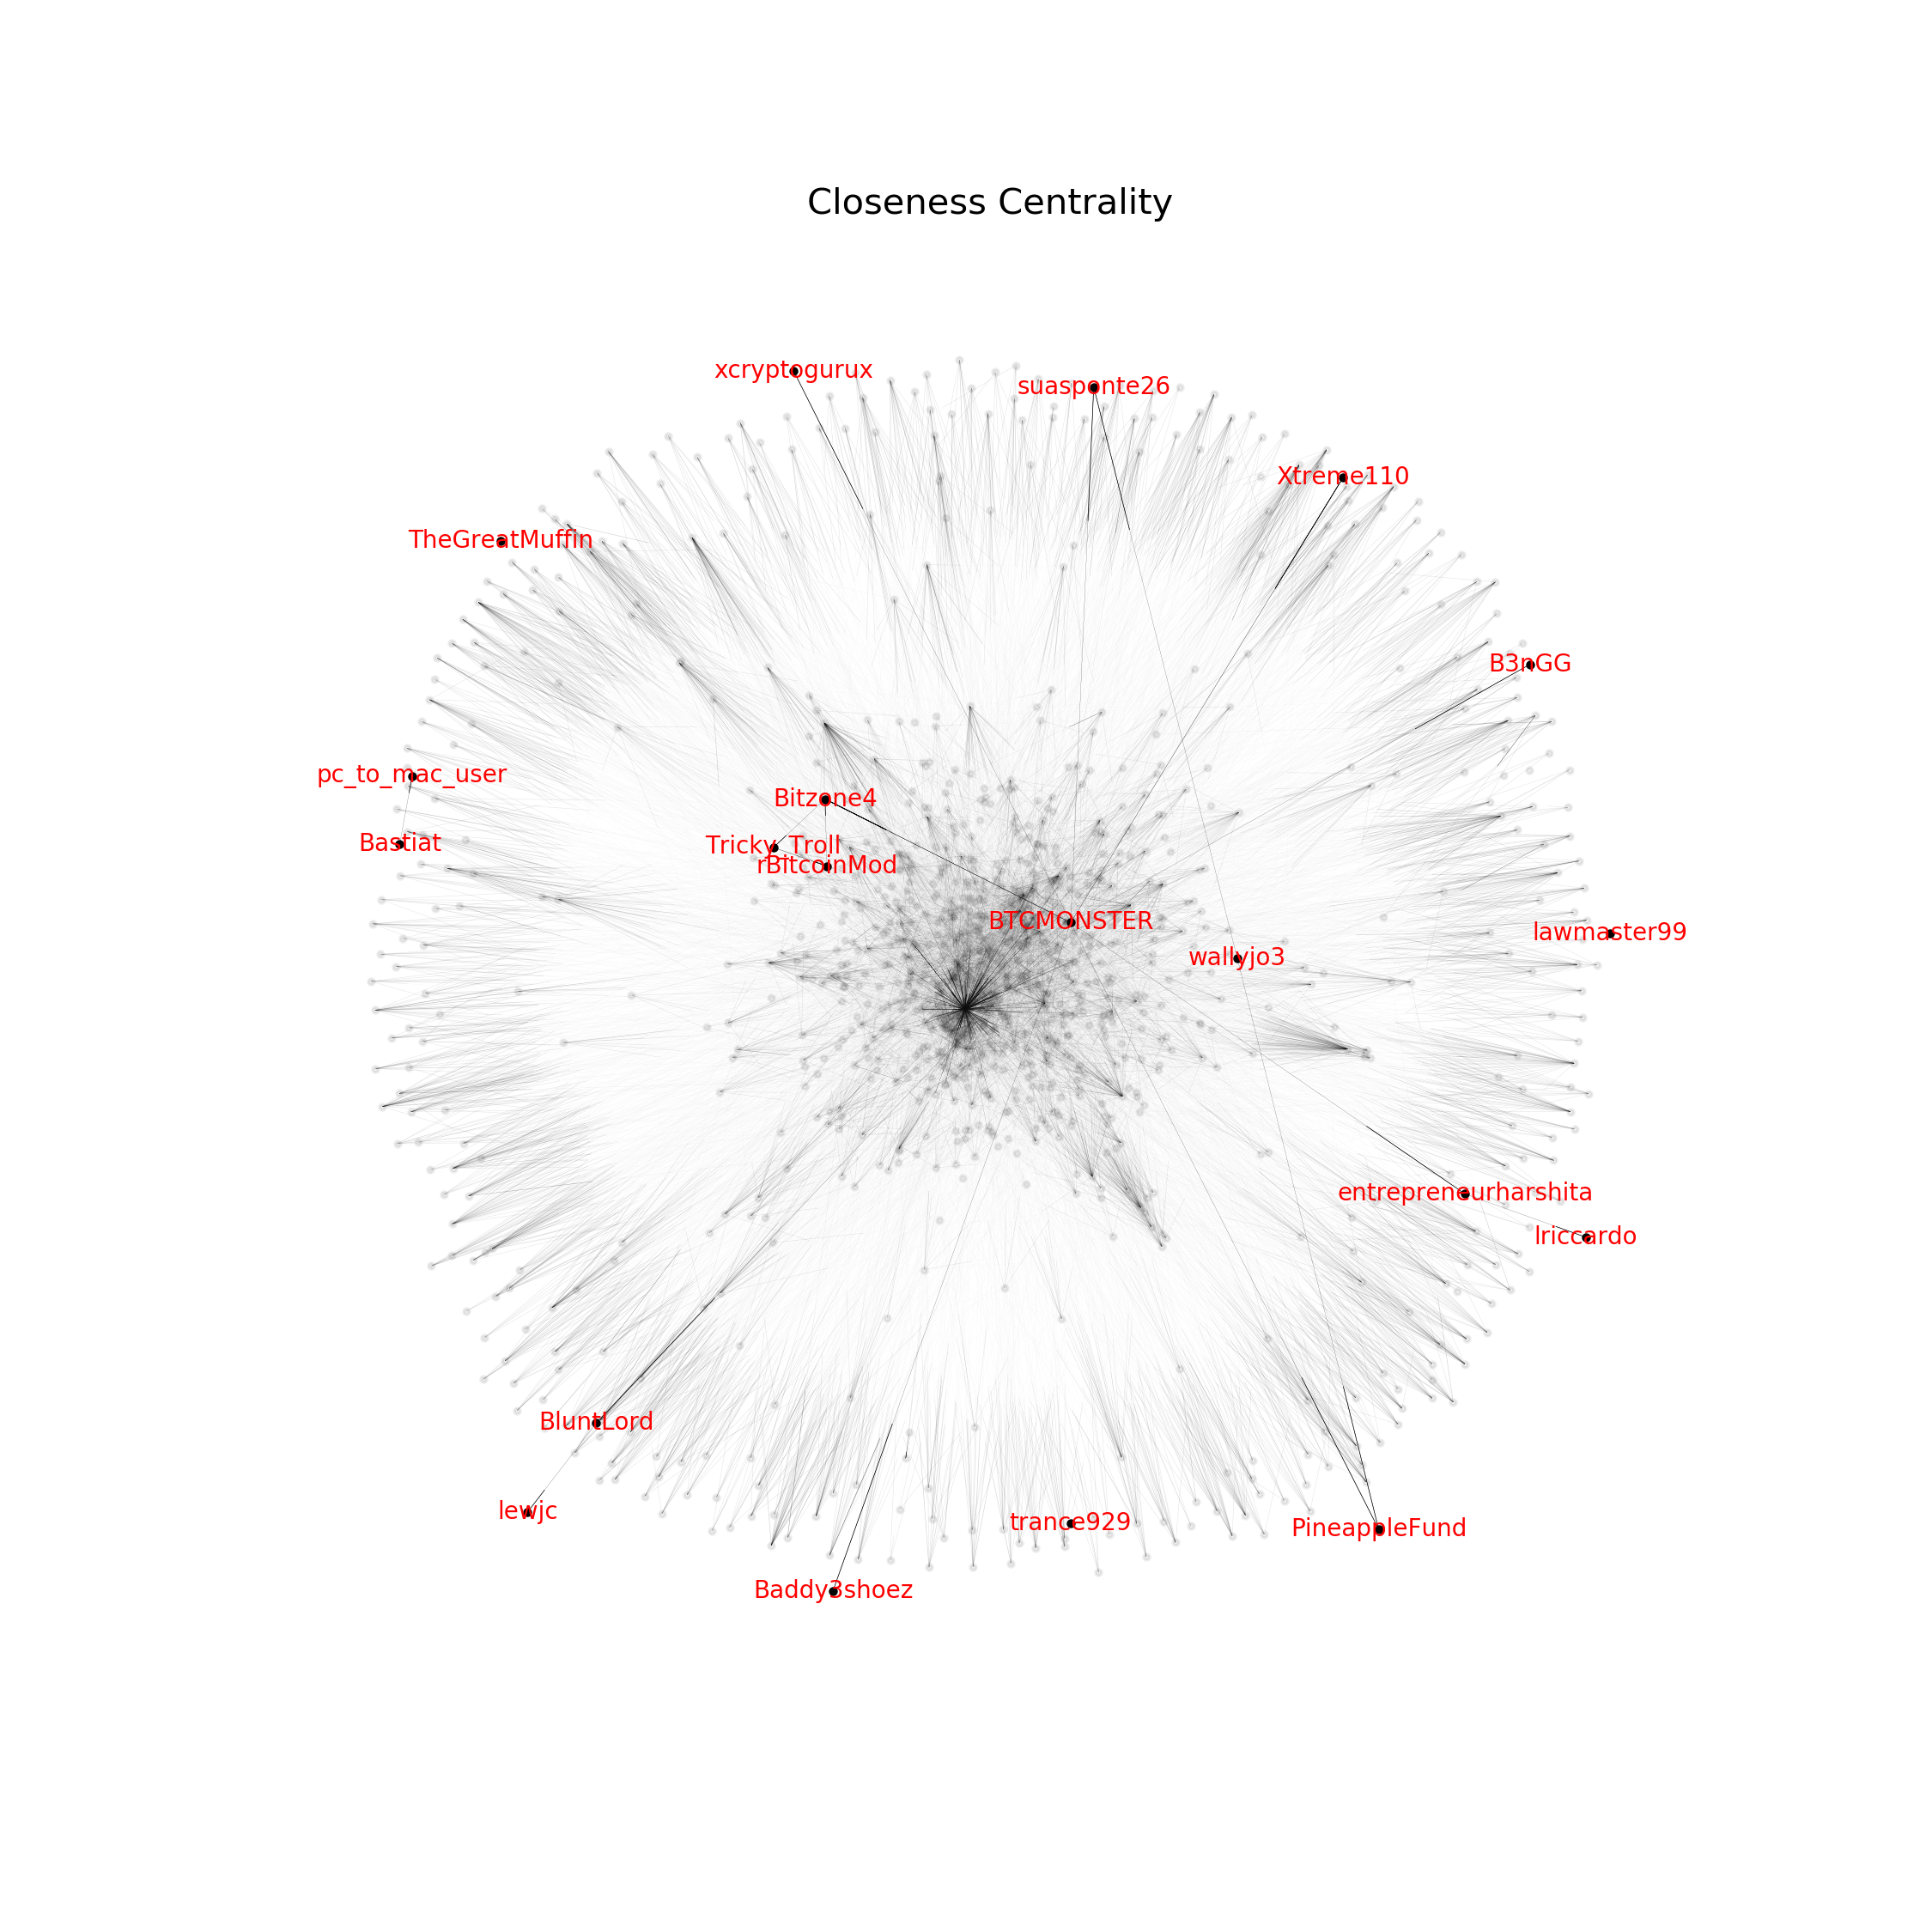

[]

In [30]:
core2 = top_n_trim(g, closeness_cen, n=25)
fig1 = plt.figure(figsize=(9,9))
ax1 = fig1.add_subplot(111)
nx.draw_networkx(core, with_labels=False, font_color='black', alpha=0.07, **options)
nx.draw_networkx(core2, with_labels=True, font_color='red', **options)
#nx.draw_networkx(core, with_labels=False, font_size=9, font_color='b', width=0.05, node_size=4, alpha=0.07, node_color='black')
#nx.draw_networkx(core2, with_labels=True, font_size=8, font_color='r', width=0.05, node_size=4, node_color='yellow')
plt.title('Closeness Centrality')
plt.axis('off')
ax1.plot()